## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

FileNotFoundError: [Errno 2] No such file or directory: 'test_1.csv'

In [7]:
dfs[0].head()

,dd,captured,pop_active_0,pop_active_1,pop_active_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,Unnamed: 11,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.001,0,2201
1,1,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.001,0,2201
2,2,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.001,0,2201
3,3,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.001,0,2201
4,4,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.001,0,2201


## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [5]:
def compile_diffs(dfs, thresh: int):
    capture_data = []
    for frame in dfs:
        first_capture = frame[frame.captured > thresh].head(1).dd
        first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1).dd
        if not first_capture.empty and not first_emergence.empty:
            diff = first_capture.iloc[0] - first_emergence.iloc[0]
            pop_0 = frame.head(1).pop_0.iloc[0]
            prob_capture = frame.head(1).prob_capture.iloc[0]
            mating_delay = frame.head(1).mating_delay.iloc[0]
            ratio_naive = pop_0 * prob_capture
            ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
            capture_data.append((diff, ratio, ratio_naive, pop_0, prob_capture, mating_delay))
    return capture_data

first_capture_data = compile_diffs(dfs, 1)

Two ratios are generated here for combinations between overwintering pop size and capture probability, a naive ratio just by multiplying them together (yes, I know this technically isn't a ratio since it's not divison, but since one of these values is very big and the other very small, multiplying gives much nicer numbers and is no less valid as a combination of the two than if I chose to multiply), and a better ratio by multiplying the cube root of the population to the cube of the capture probability. This balances out their relative importance in determining the difference much better, as will be demonstrated.

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [ ]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

capture_df.plot.scatter(1, 0, 1.5, logy=False)
capture_df.plot.scatter(2, 0, 1.5, logy=False)
capture_df.plot.scatter(3, 0, 1.5, logy=False)
capture_df.plot.scatter(4, 0, 1.5, logy=False)
capture_df.plot.scatter(5, 0, 1.5, logy=False)

## Create function for automatically fitting reciprocal functions using inverse-composition linearization

In [ ]:
def autofit_reciprocal(x, y, a_guess, b_guess, c_guess, full_output=False):
    a = a_guess
    b = b_guess
    c = c_guess
    slope = 2
    intercept = 1

    # fit 'b' parameter
    magnitude = 1
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        b_below = b + (0.1 ** magnitude)
        b_above = b - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b_above)), a), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b_below)), a), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        if abs(p[1]) < abs(p_above[1]) and abs(p[1]) < abs(p_below[1]):
            magnitude = magnitude + 1
        elif abs(p_above[1]) < abs(p_below[1]):
            b = b_above
        elif abs(p_below[1]) < abs(p_above[1]):
            b = b_below

    # fit 'a' parameter
    magnitude = 0
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        a_below = a + (0.1 ** magnitude)
        a_above = a - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_above), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_below), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        # print(f'{a}, {p_above[0]}, {p[0]}, {p_below[0]}')
        if abs(p[0] - 1) < abs(p_above[0] - 1) and abs(p[0] - 1) < abs(p_below[0] - 1):
            magnitude = magnitude + 1
        elif abs(p_above[0] - 1) < abs(p_below[0] - 1):
            a = a_above
        elif abs(p_below[0] - 1) < abs(p_above[0] - 1):
            a = a_below
    if full_output:
        return (a, b, p)
    else:
        return (a, b)

## Fit curve to data using naive ratio

In [ ]:
x = capture_df.naive_ratio
y = capture_df.difference

c = 0.29
a, b, p = autofit_reciprocal(x, y, 3, 0.3, c, full_output=True)
print(*p)

y_linear_naive = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y_naive = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y_naive, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log') # view in log to emphasize small differences
ax.set_ylim(1, 80)
ax.set_xlabel('ratio')
ax.legend()

## Check residuals

In [ ]:
from scipy.stats import zscore

def residual_plot(x, y, fitted_y):
    data = {'ratio': x, 'residual':np.subtract(y, fitted_y)}
    residuals = pd.DataFrame(data)
    residuals = residuals[(np.abs(zscore(residuals.residual)) < 4)]
    ax = plt.axes()
    ax.scatter(residuals.ratio, residuals.residual, label='Data', s=2)
    ax.set_title('Residuals vs. ratio')
    ax.set_ylabel('Actual value - predicted value')
    ax.set_xlabel('ratio')

residual_plot(x, y, fitted_y_naive)

+/- 10 degree day heteroscedasticity could definitely be improved

## Fit curve to data using smarter ratio

In [ ]:
x = capture_df.ratio
y = capture_df.difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log') # view in log to emphasize small differences
ax.set_ylim(1, 80)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

For the ratio function of (pop_0^1/3) * (prob_capture^3), a function of y = (3.024 / x ^ 0.2) + 0.965 predicts the difference in first emergence and first capture.

## Determine goodness of fit by looking at residuals

### Residual Plot

In [ ]:
residual_plot(x, y, fitted_y)

Definitely still some heteroscedasticity, but it looks like the worst of it is only +/- 3, and the majority of points seem to be in the +/- 1 area. Measureable improvement from the naive ratio. Furthermore, from looking at the fitted curve graphs of the two, no value of 'c' was able to match both the extreme and median points to a satisfactory degree with the naive ratio, but a 'c' of 0.2 matches both quite well with the smarter combination

### Measure how bad the heteroscedasticity is within the unstable small values area

In [ ]:
from scipy.ndimage import gaussian_filter1d

rolling_avg = gaussian_filter1d(np.subtract(y, fitted_y), 15, mode='nearest')

ax = plt.axes()
ax.scatter(x, np.subtract(y, fitted_y), label='Data', s=2)
ax.scatter(x, rolling_avg, label='Gaussian Rolling Avg', s=1)
ax.set_title('Residuals vs. ratio')
ax.set_ylabel('Actual value - predicted value')
ax.set_xlabel('ratio')
ax.legend()

With a gaussian weighted rolling average with a standard deviation of 15, it does appear the vast majority of all residuals hang within the +/- 1.0 range, which is definitely below noise for field emergences/captures. I am quite satisfied with this, though I do think the ultimate root cause of the heteroscedasticity could probably be weeded out given enough time and the residuals could be made 100% normally distributed. For now, this is well within the bounds of utility.

### Average bias per point

In [ ]:
np.sum(np.subtract(y, fitted_y)) / len(x)

The fitted curve is a little biased negative relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.

## At this point I decide to rethink which parameter I want to base the model off of

My rationale is this: One of the biggest issues I'm facing in making this model is the extreme instability around small ratio values, and if you look at the difference vs predictor graphs I have towards the top, you can visually see that it is mostly the fault of the "size of the overwintering population" (pop_0) to blame for this. Furthermore, this parameter would be _very_ difficult to get an actual read on in the field. The capture probability parameter is both more uniformly stable around small values, and also is actually feasible to estimate in real world situations, so I'm going to generate a new data set, holding both mating delay and pop_0 constant, so as to get a direct look at the effect of the per degree day capture probability with significantly higher resolution. I also had to modify the data output from the simulation to get an integrated energence value, as the current system for using the population active works explicitly only for the first emergence, as any past that are subject to death and capture diminishing the true number of emergences.

## Build DataFrames for the new focused set

In [2]:
df = pd.read_csv('test_2.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

In [3]:
dfs[0].head()

,dd,captured,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,Unnamed: 14,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.0001,0,2201
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.0001,0,2201
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.0001,0,2201
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.0001,0,2201
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.0001,0,2201


In [4]:
thresh = 20
frame = dfs[200]
first_capture = frame[frame.captured > thresh].head(1)
first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1)
if not first_capture.empty and not first_emergence.empty:
    diff = first_capture.dd.iloc[0] - first_emergence.dd.iloc[0]
    print(f'{first_capture.dd.iloc[0]}, {first_emergence.dd.iloc[0]}, {diff}')
pd.concat([first_capture.head(), first_emergence.head()])

121, 111, 10


,dd,captured,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,Unnamed: 14,pop_0,prob_capture,mating_delay,dd_span
440321,121,21.234134,11.174637,0.0,0.0,38.439650,0.0,0.0,961.560350,1768.936729,0.0,1000,1768.936729,0.0,NaN,1000,0.10005,0,2201
440311,111,10.440557,7.780040,0.0,0.0,20.018265,0.0,0.0,979.981735,860.300407,0.0,1000,860.300407,0.0,NaN,1000,0.10005,0,2201


## Investigate also how the difference evolves when looking at second captures, third captures, etc.

### Compile 1st through 25th differences

In [6]:
diffs = []
for i in range(1,26):
    row = compile_diffs(dfs, i)
    row_df = pd.DataFrame(row, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
    diffs.append(row_df)

len(diffs)

25

### Look at the graphs of the first, second, third, fifth, tenth, and twentieth differences against the probability of capture

<Axes: title={'center': 'Twentieth diffs'}, xlabel='prob_capture', ylabel='difference'>

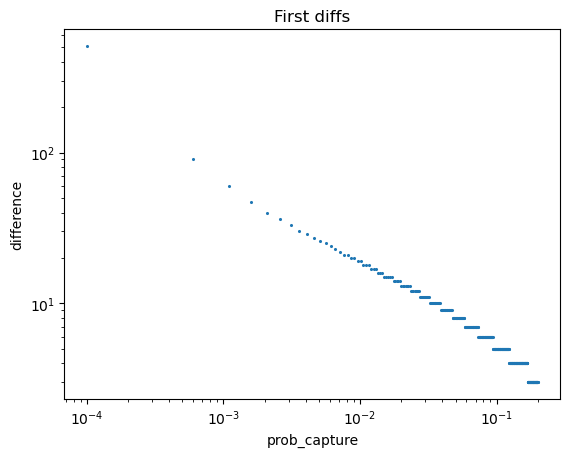

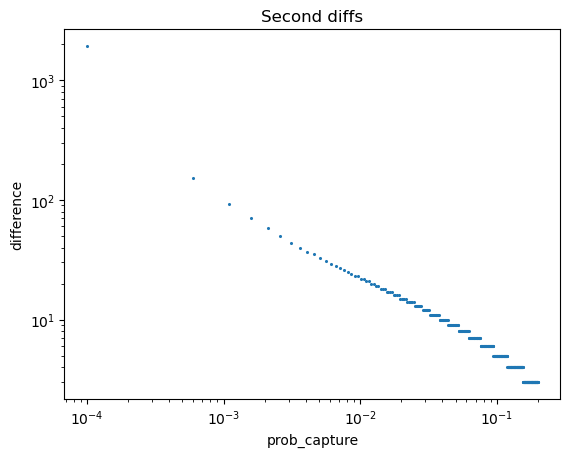

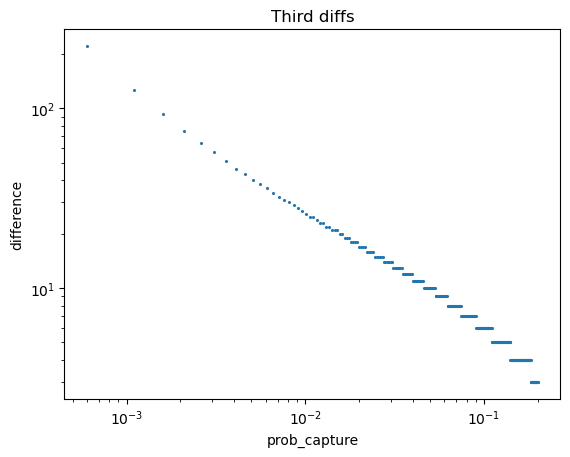

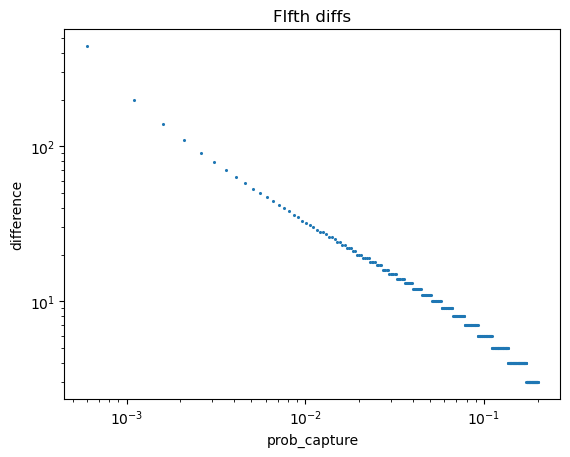

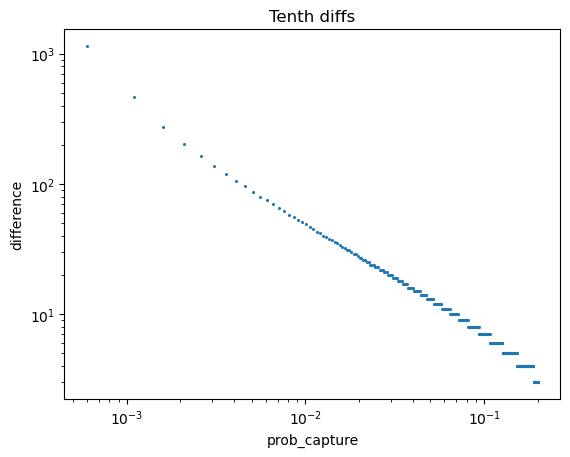

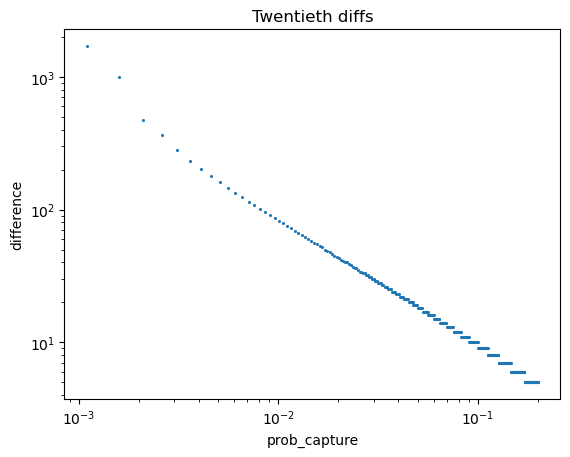

In [17]:
is_log = True
diffs[0].plot.scatter(4, 0, 1.5, title='First diffs', loglog=is_log)
diffs[1].plot.scatter(4, 0, 1.5, title='Second diffs', loglog=is_log)
diffs[2].plot.scatter(4, 0, 1.5, title='Third diffs', loglog=is_log)
diffs[4].plot.scatter(4, 0, 1.5, title='FIfth diffs', loglog=is_log)
diffs[9].plot.scatter(4, 0, 1.5, title='Tenth diffs', loglog=is_log)
diffs[19].plot.scatter(4, 0, 1.5, title='Twentieth diffs', loglog=is_log)

## Make a better fitting function for the more well behaved data

In [13]:
import statsmodels.formula.api as smf

def new_autofit(x, y, full_output=False):
    data = pd.DataFrame({'difference':y, 'prob_capture':x})
    model = smf.ols('np.log(difference) ~ np.log(prob_capture)', data=data).fit()
    return (model.params[1], model.params[0])


(-0.7078228893131745, -0.028807972257314438)


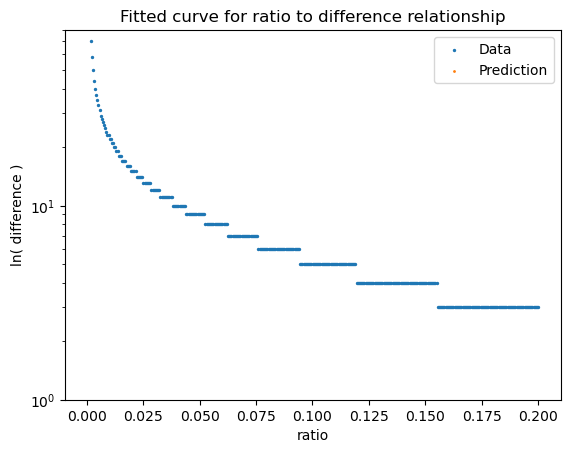

In [33]:
x = diffs[1].prob_capture
y = diffs[1].difference

a, b = new_autofit(x, y)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(x, a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(1, 80)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

In [ ]:
residual_plot(x, y, fitted_y)

In [ ]:
x = diffs[2].ratio
y = diffs[2].difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log') # view in log to emphasize small differences
ax.set_ylim(1, 80)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

In [ ]:
residual_plot(x, y, fitted_y)